<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DA0101EN-SkillsNetwork/labs/Module%202/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

# Data Wrangling

Estimated time needed: **30** minutes

## Objectives

After completing this lab you will be able to:

*   Handle missing values
*   Correct data format
*   Standardize and normalize data


<h2>Table of Contents</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
    <li><a href="https://#identify_handle_missing_values">Identify and handle missing values</a>
        <ul>
            <li><a href="https://#identify_missing_values">Identify missing values</a></li>
            <li><a href="https://#deal_missing_values">Deal with missing values</a></li>
            <li><a href="https://#correct_data_format">Correct data format</a></li>
        </ul>
    </li>
    <li><a href="https://#data_standardization">Data standardization</a></li>
    <li><a href="https://#data_normalization">Data normalization (centering/scaling)</a></li>
    <li><a href="https://#binning">Binning</a></li>
    <li><a href="https://#indicator">Indicator variable</a></li>
</ul>

</div>

<hr>


<h2>What is the purpose of data wrangling?</h2>


Data wrangling is the process of converting data from the initial format to a format that may be better for analysis.


<h3>What is the average coin cost in USDT?</h3>


<h3>Import data</h3>
<p>
You can find the "Finance Dataset" from the following link: <a href="https://1824251045.rsc.cdn77.org/web/algohouse/data/ADABUSD_trades_1m.csv">https://1824251045.rsc.cdn77.org/web/algohouse/data/ADABUSD_trades_1m.csv</a>. 
We will be using this dataset throughout this course.
</p>


<h4>Import pandas</h4> 


If you are running the lab in your  browser, run the code below to install the libraries using `piplite`


In [766]:
import piplite
await piplite.install(['pandas'])
await piplite.install(['matplotlib'])

If you run the lab locally using Anaconda, you can load the correct library and versions by uncommenting the following:


In [767]:
#If you run the lab locally using Anaconda, you can load the correct library and versions by uncommenting the following:
#install specific version of libraries used in lab
#! mamba install pandas==1.3.3
#! mamba install numpy=1.21.2


Now, let's import libraries that we will use

In [768]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import warnings

from sklearn.preprocessing import MinMaxScaler
from typing import List, Tuple
from matplotlib import pyplot


This function will download the dataset into your browser


In [769]:
#This function will download the dataset into your browser 
from pyodide.http import pyfetch

async def download(url, filename):
    response = await pyfetch(url)
    if response.status == 200:
        with open(filename, 'wb') as f:
            f.write(await response.bytes())



<h2>Reading the dataset from the URL and adding the related headers</h2>


First, we assign the URL of the dataset to "filename".


In [770]:
filename = 'https://1824251045.rsc.cdn77.org/web/algohouse/data/ADABUSD_trades_1m.csv'

You will need to download the dataset; if you are running locally, please comment out the following


In [771]:
await download(filename, 'ADABUSD_trades_1m.csv')
filename='ADABUSD_trades_1m.csv'

Use the Pandas method <b>read_csv()</b> to load the data from the web address.
Our dataset contains index column which is the first column, and headers, so we will set the parameter <code>index_col=0</code> to use first column as index columns.


In [772]:
df = pd.read_csv(filename, index_col=0)

Use the method <b>head()</b> to display the first five rows of the dataframe.


In [773]:
# To see what the data set looks like, we'll use the head() method.
df.head()

,ts,open,high,low,close,volume,rec_count,avg_price
0,2022-11-11 14:38:00,0.3450,0.3450,0.3438,0.3438,139808.0,44,0.344496
1,2022-11-11 14:39:00,0.3437,0.3441,0.3436,0.3440,80960.0,41,0.343841
2,2022-11-11 14:40:00,0.3439,0.3442,0.3432,0.3433,149624.0,42,0.343694
3,2022-11-11 14:41:00,0.3432,0.3448,0.3426,0.3446,165967.0,47,0.343953
4,2022-11-11 14:42:00,0.3446,0.3448,0.3438,0.3438,34815.0,27,0.344382


Let's capitalize names of the columns

In [774]:
current_columns = df.columns

capitalized_columns = [v.capitalize() for v in current_columns]
capitalized_columns


['Ts', 'Open', 'High', 'Low', 'Close', 'Volume', 'Rec_count', 'Avg_price']

And replace old names inside dataframe

In [775]:
df.columns = capitalized_columns
df.columns

Index(['Ts', 'Open', 'High', 'Low', 'Close', 'Volume', 'Rec_count',
       'Avg_price'],
      dtype='object')

Let's make a copy of our input dataframe(we will need it later).

In [776]:
df_copy = df.copy()

As we can see, our dataset does not have any missing values, but in the real world, it is not always like this; more often, our datasets need some preprocessing to be done. So for the sake of this exercise, we will create missing values and wrong values and then learn how to work with such data.

So let's add some negative values first.

In [777]:
def raise_warning(column: str, type: str = 'negative'): 
  """Common warning function used to raise warnings that some values are already in our column"""
  warning_error: str = f'Column {column} already has some {type} values! '
  warning_message: str = f'Column {column} was not changed'
  warning_note: str = f'Note: columns listed before {column} where changed!'        
  warnings.warn(warning_error + 
                warning_message + 
                warning_note)


In [778]:
columns_to_add_negative_values = [('Volume', 0.75), ('Rec_count', 0.002)]

In [779]:
def has_negative_values(df: pd.DataFrame, 
                       column: str) -> bool:
  """Checks if dataframe column has negative values
    :param df is a dataframe with the column we want to check
    :param column is the name of the column
  """         
  tmp_column = df[column].where(df[column] >= 0)
  return tmp_column.isna().sum() > 0


def create_negative_values(df: pd.DataFrame, 
                     columns: List[Tuple[str, int or float]]) ->  pd.DataFrame:
  """Adds negative values into specific columns of the dataframe if they 
     do not contain negative values already.
    :param df is a dataframe where you want to add some negative values
    :param columns is a list of column names and probabilities of each 
           cell becoming negative value
           Example: [('first_column', .5), ('second_column', .1)]
    :return updated dataframe or old dataframe 
            if negative values already exist in one of the columns
  """
  for column, percentage in columns:
    if has_negative_values(df, column):
      raise_warning(column)
      return df
    column_shape = df[column].shape
    condition_df = np.random.random(column_shape) < percentage
    df[column] = np.where(condition_df, -df[column], df[column])
  return df
  

In [780]:
df = create_negative_values(df, columns_to_add_negative_values)

In [781]:
df.head()

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price
0,2022-11-11 14:38:00,0.3450,0.3450,0.3438,0.3438,139808.0,44,0.344496
1,2022-11-11 14:39:00,0.3437,0.3441,0.3436,0.3440,80960.0,41,0.343841
2,2022-11-11 14:40:00,0.3439,0.3442,0.3432,0.3433,-149624.0,42,0.343694
3,2022-11-11 14:41:00,0.3432,0.3448,0.3426,0.3446,-165967.0,47,0.343953
4,2022-11-11 14:42:00,0.3446,0.3448,0.3438,0.3438,-34815.0,27,0.344382


Sometimes some columns may be of one type, but represented as absolutely different type that is not convinient for us. Let's change types of some columns to 'wrong' types.

In [782]:
df = df.astype({'Open': 'string', 'Close': 'string', 'Volume': 'string'})

Let's see the dataframe types to make sure everything worked as expected

In [783]:
df.dtypes

Ts            object
Open          string
High         float64
Low          float64
Close         string
Volume        string
Rec_count      int64
Avg_price    float64
dtype: object

<b>Now, let's add missing values</b>

We will use the question mark '?' for the missing values. To replace some values <code>mask</code> method will be used. This method takes condition dataframe, which is a dataframe of boolean values for each cell. Parameter <code>other</code> specifies value that will be inserted.

In [784]:
def has_missing_values(df: pd.DataFrame, 
                       column: str, 
                       missing_value: str) -> bool:
  """Checks if dataframe column has missing values
    :param df is a dataframe with the column we want to check
    :param column is the name of the column
    :param missing_value specifies value that is considered to be a
           missing value
  """         
  tmp_column = df[column].replace(missing_value, np.nan)
  return tmp_column.isna().sum() > 0

def add_missing_data(df: pd.DataFrame, 
                     columns: List[Tuple[str, int or float]],
                     missing_value: str ='?') -> pd.DataFrame:
  """Adds missing values into specific columns of the dataframe if they 
     do not contain missing values already
    :param df is a dataframe where you want to add some missing value
    :param columns is a list of column names and probabilities of each 
           cell being replaced by a missing value
           Example: [('first_column', .5), ('second_column', .1)]
    :param missing_value specifies value that is 
           considered to be a missing value
    :return updated dataframe
  """
  for column, percentage in columns:
    if has_missing_values(df, column, missing_value):
      raise_warning(column, type='missing')
      return df
    column_shape = df[column].shape
    condition_df = np.random.random(column_shape) < percentage
    df[column] = df[column].mask(condition_df, other=missing_value)
  return df

Let's create an array of columns that are going to have some missing values(in our case '?').

In [785]:
columns_to_add_missing_data = [('Volume', 0.015), ('Rec_count', 0.02)]

Make sure to run the below code once, as running one more time won't change the dataframe, but will cause warning.

In [786]:
df = add_missing_data(df, columns_to_add_missing_data)

In [787]:
df.head(50)

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price
0,2022-11-11 14:38:00,0.345,0.3450,0.3438,0.3438,139808.0,44,0.344496
1,2022-11-11 14:39:00,0.3437,0.3441,0.3436,0.344,80960.0,41,0.343841
2,2022-11-11 14:40:00,0.3439,0.3442,0.3432,0.3433,-149624.0,42,0.343694
3,2022-11-11 14:41:00,0.3432,0.3448,0.3426,0.3446,-165967.0,47,0.343953
4,2022-11-11 14:42:00,0.3446,0.3448,0.3438,0.3438,-34815.0,27,0.344382


As we can see, our dataframe is more realistic now and has wrong values, types and several question marks in the dataframe(those are missing values which may hinder our further analysis). Now, we can learn how to work with such data.


<i><b>So, how do we identify all those missing values and deal with them?</b></i>

<b>How to work with missing data?</b>

Steps for working with missing data:

<ol>
    <li>Identify missing data</li>
    <li>Deal with missing data</li>
    <li>Correct data format</li>
</ol>

<i><b>How do we identify all the dirty values; how to deal with them?</b></i>

<b>How to work with dirty data?</b>

Steps for working with dirty data:

<ol>
    <li>Identify columns with dirty data</li>
    <li>Deal with dirty data</li>
    <li>Correct data format</li>
</ol>

<h2 id="identify_handle_missing_values">Identify and handle missing values</h2>

<h3 id="identify_missing_values">Identify missing values</h3>
<h4>Convert "?" to NaN</h4>
In our dataset, missing data comes with the question mark "?".
So let's replace "?" with NaN (Not a Number), Python's default missing value marker for reasons of computational speed and convenience. Here we use the function: 
 <pre>.replace(A, B, inplace = True) </pre>
to replace A by B.
Doing so enables us to use convinient pandas methods for working with missing data(You can find them few cells below)

In [788]:
import numpy as np

df.replace('?', np.nan, inplace = True)
df.head(50)

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price
0,2022-11-11 14:38:00,0.345,0.3450,0.3438,0.3438,139808.0,44.0,0.344496
1,2022-11-11 14:39:00,0.3437,0.3441,0.3436,0.344,80960.0,41.0,0.343841
2,2022-11-11 14:40:00,0.3439,0.3442,0.3432,0.3433,-149624.0,42.0,0.343694
3,2022-11-11 14:41:00,0.3432,0.3448,0.3426,0.3446,-165967.0,47.0,0.343953
4,2022-11-11 14:42:00,0.3446,0.3448,0.3438,0.3438,-34815.0,27.0,0.344382


In [789]:
df.dtypes

Ts            object
Open          string
High         float64
Low          float64
Close         string
Volume        string
Rec_count    float64
Avg_price    float64
dtype: object

<h4>Evaluating for Missing Data</h4>

The missing values are converted by default. We use the following functions to identify these missing values. There are two methods to detect missing data:

<ol>
    <li><b>.isnull()</b></li>
    <li><b>.notnull()</b></li>
</ol>
The output is a boolean value indicating whether the value that is passed into the argument is in fact missing data.


In [790]:
missing_data = df.isnull()
missing_data.head(50)

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False


"True" means the value is a missing value while "False" means the value is not a missing value.


<h4>Count missing values in each column</h4>
<p>
Using a for loop in Python, we can quickly figure out the number of missing values in each column. As mentioned above, "True" represents a missing value and "False" means the value is present in the dataset.  In the body of the for loop the method ".value_counts()" counts the number of "True" values. 
</p>


In [791]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print('')    

Ts
False    65303
Name: Ts, dtype: int64

Open
False    65303
Name: Open, dtype: int64

High
False    65303
Name: High, dtype: int64

Low
False    65303
Name: Low, dtype: int64

Close
False    65303
Name: Close, dtype: int64

Volume
False    64359
True       944
Name: Volume, dtype: int64

Rec_count
False    64017
True      1286
Name: Rec_count, dtype: int64

Avg_price
False    65303
Name: Avg_price, dtype: int64



Based on the summary above, you can analyze how many cells have a missing data. Number near True is number of cells with missing values, vice versa for False.


<h3 id="deal_missing_values">Deal with missing data</h3>
<b>How to deal with missing data?</b>

<ol>
    <li>Drop data<br>
        a. Drop the whole row<br>
        b. Drop the whole column
    </li>
    <li>Replace data<br>
        a. Replace it by mean<br>
        b. Replace it by frequency<br>
        c. Replace it based on other functions<br>
        d. Replace it by imputed value
    </li>
</ol>


Whole columns should be dropped only if most entries in the column are empty. In our dataset, none of the columns are empty enough to drop entirely.
We have some freedom in choosing which method to replace data; however, some methods may seem more reasonable than others. We will apply each method to many different columns:
<ul>
    <li>Column "Volume": has 1.5% probability of cell being missing data. Use interpolation to fill missing values.
    </li>
    <li>Column "Rec_count": has 0.2% probability of cell being missing data. Use interpolation to fill missing values.</li>
</ul>



First of all, let's get rid of negative values.

For that we convert data_types and replace NaN with float('inf'). 
We need float('inf') as it will help us to get rid of negative values(there will be no method restrictions).


In [792]:
fix_types = {
    'Volume': np.float64,
    'Rec_count': np.float64
    }
df = df.astype(fix_types)
df.replace(np.nan, float('inf'), inplace = True)

In [793]:
cols_with_neg_values = ['Volume', 'Rec_count']

In [794]:
for column in cols_with_neg_values:
    df[column] = df[column].abs()

Let's check if everything is fine by displaying dataframe and using <code>has_negative_values</code> method that we implemented previously.

In [795]:
for column in cols_with_neg_values:
  col_res = has_negative_values(df, column)
  log_res = 'contains' if col_res else 'does not contain'
  print(f'Column {column} {log_res} negative values')

Column Volume does not contain negative values
Column Rec_count does not contain negative values


Now as we do not have negative values we can replace float('inf') with np.nan

In [796]:
df.replace(float('inf'), np.nan, inplace = True)

In [797]:
methods = [{'method': 'linear', 'limit_direction': 'both'}, {'method': 'polynomial', 'order': 3}, {'method': 'pad', 'limit_direction': 'forward'}]

Now we have to interpolate missing values and choose one of the methods.

In [798]:
from sklearn.metrics import mean_absolute_percentage_error

interp_df = pd.DataFrame()

for params in methods:
  method = params['method']
  # geting mean_absolute_percentage_error for record count
  interp_df[f'{method}_rec_count'] = df['Rec_count'].interpolate(**params)
  print(f"Rec_count {method} {mean_absolute_percentage_error(df_copy['Rec_count'], interp_df[f'{method}_rec_count'])}")
  # geting mean_absolute_percentage_error for Volume
  interp_df[f'{method}_volume'] = df['Volume'].interpolate(**params)
  print(f"Volume {method} {mean_absolute_percentage_error(df_copy['Volume'], interp_df[f'{method}_volume'])}")
  

Rec_count linear 0.014098092097249685
Volume linear 0.15507671923515817
Rec_count polynomial 0.01708315128460994
Volume polynomial 0.23184260051601602
Rec_count pad 0.015862183288531412
Volume pad 0.15784521297117296


As we can see linear method fits our data the most.

In [799]:
pd.options.mode.chained_assignment = None 
df['Rec_count'] = interp_df['linear_rec_count']
df['Volume'] = interp_df['linear_volume']
pd.options.mode.chained_assignment = 'warn'

Let's check if all missing values were replaced using previously implemented <code>has_missing_values</code> method.

In [800]:
has_missing_values(df, 'Rec_count', missing_value=np.nan)

False

In [801]:
has_missing_values(df, 'Volume', missing_value=np.nan)

False

<b>Good!</b> Now, we have a dataset with no missing values.


<h3 id="correct_data_format">Correct data format</h3>
<b>We are almost there!</b>
<p>The last step in data cleaning is checking and making sure that all data is in the correct format (int, float, text or other).</p>

In Pandas, we use:

<p><b>.dtype()</b> to check the data type</p>
<p><b>.astype()</b> to change the data type</p>


<h4>Let's list the data types for each column</h4>


In [802]:
df.dtypes

Ts            object
Open          string
High         float64
Low          float64
Close         string
Volume       float64
Rec_count    float64
Avg_price    float64
dtype: object

<p>As we can see above, some columns are not of the correct data type. Numerical variables should have type <code>float</code> or <code>int</code>, datetime values should have <code>datetime</code> . For example, 'Volume' is  numerical value of type <code>float</code>; however, it is displayed <code>object</code>, same goes for 'Ts' column that is of type <code>datetime</code>. We have to convert data types into a proper format for each column using the <code>astype()</code> method.</p> 


<h4>Convert data types to proper format</h4>


In [803]:
correct_types = {'Ts': np.datetime64,
                'Open': np.float64,
                'High': np.float64,
                'Low': np.float64,
                'Close': np.float64,
                'Volume': np.float64,
                'Rec_count': np.int64,
                'Avg_price': np.float64
                 }

df = df.astype(correct_types)

<h4>Let us list the columns after the conversion</h4>


In [804]:
df.dtypes

Ts           datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
Rec_count             int64
Avg_price           float64
dtype: object

Now we have obtained the cleaned dataset with no missing values.


<h2 id="data_standardization">Data Standardization</h2>
<p>
Data is usually collected from different sources in different formats.
(Data standardization is also a term for a particular type of data normalization where we subtract the mean and divide by the standard deviation.)
</p>

<b>What is standardization?</b>

<p>Standardization is the process of transforming data into a common format, allowing the researcher to make the meaningful comparison.
</p>

<b>Example</b>

<p>Transform BUSD to USDT:</p>
<p>In our dataset, the avarage cost column "Avg_cost" is represented by BUSD unit. Assume we want to perform some analisys, but using USDT values.</p>
<p>We will need to apply <b>data transformation</b> to transform BUSD into USDT.</p>


<p>Let's use binance API to get up to date info for transformation</p>

<p>We can do many mathematical operations directly in Pandas.</p>


In [805]:
df.head()

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price
0,2022-11-11 14:38:00,0.3450,0.3450,0.3438,0.3438,139808.0,44,0.344496
1,2022-11-11 14:39:00,0.3437,0.3441,0.3436,0.3440,80960.0,41,0.343841
2,2022-11-11 14:40:00,0.3439,0.3442,0.3432,0.3433,149624.0,42,0.343694
3,2022-11-11 14:41:00,0.3432,0.3448,0.3426,0.3446,165967.0,47,0.343953
4,2022-11-11 14:42:00,0.3446,0.3448,0.3438,0.3438,34815.0,27,0.344382


In [806]:
# Convert BUSD to USDT by mathematical operation
res = await pyfetch("https://api.binance.com/sapi/v1/convert/exchangeInfo?fromAsset=BUSD&toAsset=USDT")
# If the API is unavailable we set fixed rate
if res.status != 200:
    rate = 0.999707
else:
    # Converting json to dict
    res = await res.json()
    rate = float(res[0]["toAssetMinAmount"])
    
print(f"The exchange rate is 1 BUSD = {rate} USDT")

cols_to_convert = ["Avg_price"]
for col in cols_to_convert:
    df[f"{col}_USDT"] = df[col] * rate

# check your transformed data 
df[["Avg_price_USDT"]].head(25)

The exchange rate is 1 BUSD = 1.0 USDT


,Avg_price_USDT
0,0.344496
1,0.343841
2,0.343694
3,0.343953
4,0.344382
5,0.344446
6,0.344243
7,0.346929
8,0.348925
9,0.353730


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #1: </h1>

<b>According to the example above, transform BUSD to ADA in the new column  called "ADA_avg_price".</b>

</div>


In [807]:
# Write your code below and press Shift+Enter to execute 

<details><summary>Click here for the solution</summary>

```python
# Convert BUSD to ADA by mathematical operation
res = await pyfetch("https://api.binance.com/sapi/v1/convert/exchangeInfo?fromAsset=BUSD&toAsset=ADA")
# If the api is unavailable we set fixed rate
if res.status != 200:
    rate = 2.6
else:
    # Converting json to dict
    res = await res.json()
    rate = float(res[0]["toAssetMinAmount"])
    
print(f"The exchange rate is 1 BUSD = {rate} ADA")

cols_to_convert = ["Avg_price"]
for col in cols_to_convert:
    df[f"{col}_ADA"] = df[col] * rate

# check your transformed data 
df[["Avg_price_ADA"]].head()

```

</details>


<h2 id="data_normalization">Data Normalization</h2>

<b>Why normalization?</b>

<p>Normalization is the process of transforming values of several variables into a similar range. Typical normalizations include scaling the variable so the variable average is 0, scaling the variable so the variance is 1, or scaling the variable so the variable values range from 0 to 1.
</p>

<b>Example</b>

<p>To demonstrate normalization, let's say we want to scale the columns "Rec_count" and "Volume".</p>
<p><b>Target:</b> would like to normalize those variables so their value ranges from 0 to 1</p>
<p><b>Approach:</b> Use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a> that does following computations:</p>
<ul>
<li>
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
</li>
<li>
X_scaled = X_std * (max - min) + min
</li>
</ul>
Where min, max are params from feature_range.


In [808]:
# replace (original value) by MinMaxScaler values
from sklearn.preprocessing import MinMaxScaler
# the default value of fearture_range parameter is (0, 1),
# so we do not need to specify it
scaler = MinMaxScaler()
df[['Rec_count']] = scaler.fit_transform(df[['Rec_count']])
df[['Rec_count']]

,Rec_count
0,0.380531
1,0.353982
2,0.362832
3,0.407080
4,0.230088
...,...
65298,0.044248
65299,0.026549
65300,0.053097
65301,0.017699


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question #2: </h1>

<b>According to the example above, normalize the column "Volume".</b>

</div>


In [809]:
# Write your code below and press Shift+Enter to execute 

<details><summary>Click here for the solution</summary>

```python
df[['Volume']] = scaler.fit_transform(df[['Volume']])

# show the scaled columns
df[['Volume','Rec_count']].head()

```

</details>


Here we can see we've normalized "Volume" and "Rec_count" in the range of \[0,1].


<h2 id="binning">Binning</h2>
<b>Why binning?</b>
<p>
    Binning is a process of transforming continuous numerical variables into discrete categorical 'bins' for grouped analysis.
</p>

<b>Example: </b>

<p> What if we want to see periods of time when "Avg_price" had highest values and analyse the difference between "High" and "Low" values for high, medium and low "Avg_price"?
Can we rearrange them into three ‘bins' to simplify analysis? </p>

<p>We will use the pandas method "cut" to segment the "Avg_price" column into 3 bins.</p>


<h3>Example of Binning Data In Pandas</h3>


Let's plot the histogram of Avg_price to see what the distribution of Avg_price looks like.


Text(0.5, 1.0, 'Average price bins')

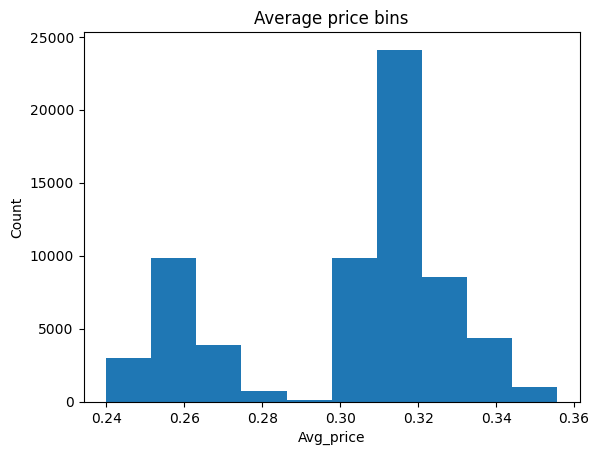

In [810]:
%matplotlib inline 
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(df["Avg_price"])

# set x/y labels and plot title
plt.pyplot.xlabel("Avg_price")
plt.pyplot.ylabel("Count")
plt.pyplot.title("Average price bins")

<p>We would like 3 bins of equal size bandwidth so we use numpy's <code>linspace(start_value, end_value, numbers_generated</code> function.</p>
<p>Since we want to include the minimum value of "Avg_price" column, we want to set start_value = min(df["Avg_price"]).</p>
<p>Since we want to include the maximum value of "Avg_price" column, we want to set end_value = max(df["Avg_price"]).</p>
<p>Since we are building 3 bins of equal length, there should be 4 dividers, so numbers_generated = 4.</p>


We build a bin array with a minimum value to a maximum value by using the bandwidth calculated above. The values will determine when one bin ends and another begins.


In [811]:
bins = np.linspace(min(df['Avg_price']), max(df['Avg_price']), 4)
bins

array([0.23993806, 0.27850777, 0.31707748, 0.3556472 ])

We set group  names:


In [812]:
group_names = ['Low', 'Medium', 'High']

We apply the function "cut" to determine what each value of `df['Avg_price']` belongs to.


In [813]:
df['Avg_price_binned'] = pd.cut(df['Avg_price'], bins, labels=group_names, include_lowest=True )
df[['Avg_price','Avg_price_binned']].head(20)

,Avg_price,Avg_price_binned
0,0.344496,High
1,0.343841,High
2,0.343694,High
3,0.343953,High
4,0.344382,High
5,0.344446,High
6,0.344243,High
7,0.346929,High
8,0.348925,High
9,0.353730,High


Let's see the number of records in each bin:


In [814]:
df["Avg_price_binned"].value_counts()

Medium    28732
High      19858
Low       16713
Name: Avg_price_binned, dtype: int64

Let's plot the distribution of each bin:


Text(0.5, 1.0, 'Average price bins')

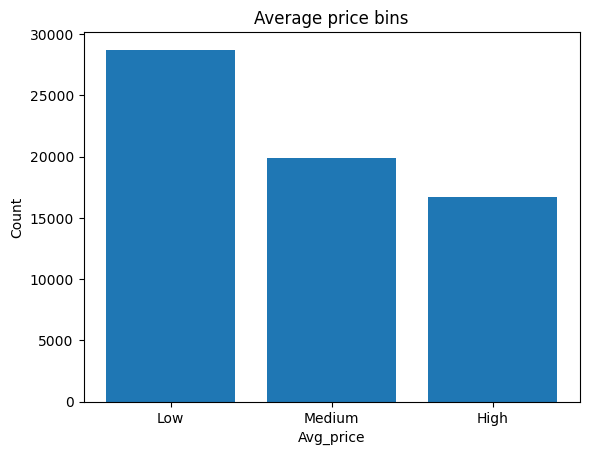

In [815]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

pyplot.bar(group_names, df["Avg_price_binned"].value_counts())

# set x/y labels and plot title
plt.pyplot.xlabel("Avg_price")
plt.pyplot.ylabel("Count")
plt.pyplot.title("Average price bins")

<p>
    Good, we devided our dataset into bins by "Avg_price" based on 3 categories ("Low", "Medium" and "High"). 
</p>

<h3>Bins Visualization</h3>
Normally, a histogram is used to visualize the distribution of bins we created above. 


Text(0.5, 1.0, 'Avarage price bins')

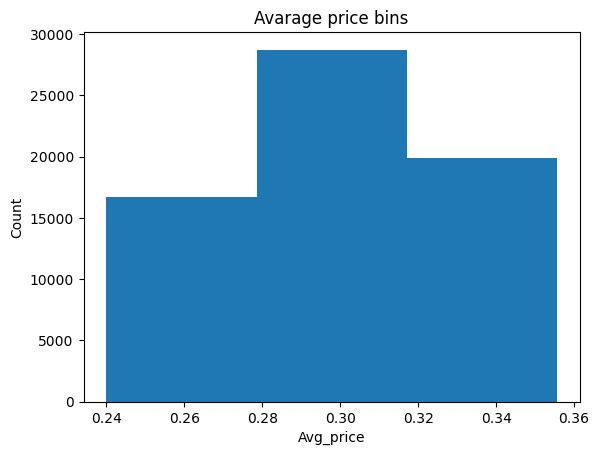

In [816]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot


# draw historgram of attribute "High" with bins = 3
plt.pyplot.hist(df["Avg_price"], bins = 3)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg_price")
plt.pyplot.ylabel("Count")
plt.pyplot.title("Avarage price bins")

The plot above shows the binning result for the attribute "Avg_price".


In [817]:
dummy_variable = pd.get_dummies(df['Avg_price_binned'])
dummy_variable

,Low,Medium,High
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
65298,1,0,0
65299,1,0,0
65300,1,0,0
65301,1,0,0


Change the column names for clarity:

In [818]:
dummy_variable.rename(columns={'Low':'Low_bin', 'Medium':'Medium_bin', 'High': 'High_bin'}, inplace=True)

In [819]:
# merge data frame "df" and "dummy_variable" 
df = pd.concat([df, dummy_variable], axis=1)

# drop original column "Avg_price_binned" from "df"
df.drop("Avg_price_binned", axis = 1, inplace=True)

In [820]:
df.head()

,Ts,Open,High,Low,Close,Volume,Rec_count,Avg_price,Avg_price_USDT,Low_bin,Medium_bin,High_bin
0,2022-11-11 14:38:00,0.3450,0.3450,0.3438,0.3438,139808.0,0.380531,0.344496,0.344496,0,0,1
1,2022-11-11 14:39:00,0.3437,0.3441,0.3436,0.3440,80960.0,0.353982,0.343841,0.343841,0,0,1
2,2022-11-11 14:40:00,0.3439,0.3442,0.3432,0.3433,149624.0,0.362832,0.343694,0.343694,0,0,1
3,2022-11-11 14:41:00,0.3432,0.3448,0.3426,0.3446,165967.0,0.407080,0.343953,0.343953,0,0,1
4,2022-11-11 14:42:00,0.3446,0.3448,0.3438,0.3438,34815.0,0.230088,0.344382,0.344382,0,0,1


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #3: </h1>

<b>Create an indicator variable for the list of values: <code>['apple', 'orange', 'banana']</code></b>

</div>


In [821]:
# Write your code below and press Shift+Enter to execute 

<details><summary>Click here for the solution</summary>

```python
# get indicator variables for list of values and assign it to data frame "dummy_variable_1"
list_of_values = ['apple', 'orange', 'banana']
dummy_variable_1 = pd.get_dummies(list_of_values)

dummy_variable_1.head()


```

</details>


<div class="alert alert-danger alertdanger" style="margin-top: 20px">
<h1> Question  #4: </h1>

<b>Similar to before, create bins for the column "High" with four group names. Plot the distribution of each bin. </b>

</div>


In [822]:
# Write your code below and press Shift+Enter to execute 

<details><summary>Click here for the solution</summary>

```python
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

bins = np.linspace(df['High'].min(), df['High'].max(), 5)
print(bins)

group_names = ['Hlow_bin', 'Hmedium_Low_bin', 'Hmedium_High_bin' , 'Hhigh_bin']

df['High_binned'] = pd.cut(df['High'], bins, labels=group_names, include_lowest=True)
pyplot.bar(group_names, df["High_binned"].value_counts())

plt.pyplot.hist(df["High"])

plt.pyplot.xlabel("High ")
plt.pyplot.ylabel("Count")
plt.pyplot.title("High bins")
```

</details>


<h3>Resampling</h3>


Time series data can be summarized or aggregated by a new time interval. For example, you can summarize minute data into hours, hours into days, etc.

This process of changing the time period data to be summarized into another time period is often called resampling.

Let's resample our data from 1 minute to 5 minutes, we will use <code>pandas</code> <code>resample()</code> method for this purpose.

In [823]:
df['Ts'] = pd.to_datetime(df['Ts'])
df.set_index('Ts', inplace=True)

Now we create new dataframe and write aggragated data in it. 

In [824]:
resample_df5 = pd.DataFrame()
resample_df5['Open'] = df['Open'].resample('5min').first()
resample_df5['High'] = df['High'].resample('5min').max()
resample_df5['Low'] = df['Low'].resample('5min').min()
resample_df5['Close'] = df['Close'].resample('5min').last()
resample_df5['Volume'] = df['Volume'].resample('5min').sum()

Let's aggregate data to 10 minutes, using shorter syntax.

In [825]:
resample_df10 = df[["Open", "High", "Low", "Close", "Volume"]].resample("10min").agg({
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum"
})

In the above cell we specified time and how our aggragated data will be aggregated.

> <i>For example:</i> for 'Volume' all values(within 5 minutes intervals) in that column will be summed up; for 'Close' we get last value from 5-minute interval; for 'High' we get maximum value within 5-minute intervals.

In [826]:
resample_df

,Open,High,Low,Close,Volume
Ts,,,,,
2022-11-11 14:35:00,0.3450,0.3450,0.3436,0.3440,220768.0
2022-11-11 14:40:00,0.3439,0.3448,0.3426,0.3448,470475.0
2022-11-11 14:45:00,0.3448,0.3568,0.3448,0.3530,3989853.0
2022-11-11 14:50:00,0.3529,0.3545,0.3487,0.3496,1435676.0
2022-11-11 14:55:00,0.3496,0.3511,0.3473,0.3498,985189.0
...,...,...,...,...,...
2022-12-29 23:35:00,0.2443,0.2443,0.2439,0.2439,294727.0
2022-12-29 23:40:00,0.2439,0.2441,0.2437,0.2440,171401.0
2022-12-29 23:45:00,0.2440,0.2440,0.2434,0.2436,144450.0


As you can see we successfully resampled our 1 minute intervals. Let's save new datasets into csv file

In [827]:
resample_df.to_csv('ADA BUSD 5min.csv')
resample_df.to_csv('ADA BUSD 10min.csv')

### Thank you for completing this lab!

## Author

<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01" target="_blank">Joseph Santarcangelo</a>

### Other Contributors

<a href="https://www.linkedin.com/in/mahdi-noorian-58219234/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01" target="_blank">Mahdi Noorian PhD</a>

Bahare Talayian

Eric Xiao

Steven Dong

Parizad

Hima Vasudevan

<a href="https://www.linkedin.com/in/fiorellawever/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkDA0101ENSkillsNetwork20235326-2021-01-01" target="_blank">Fiorella Wenver</a>

<a href="https:// https://www.linkedin.com/in/yi-leng-yao-84451275/ " target="_blank" >Yi Yao</a>.

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By | Change Description                  |
| ----------------- | ------- | ---------- | ----------------------------------- |
| 2022-04-22        | 2.3     | Lakshmi    | Made changes in markdown file       |
| 2020-10-30        | 2.2     | Lakshmi    | Changed URL of csv                  |
| 2020-09-09        | 2.1     | Lakshmi    | Updated Indicator Variables section |
| 2020-08-27        | 2.0     | Lavanya    | Moved lab to course repo in GitLab  |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>
